In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [35]:
from sqlalchemy.inspection import inspect
for table_name in inspect(engine).get_table_names():
    print(table_name)

measurement
station


In [36]:
from sqlalchemy.inspection import inspect
inspector=inspect(engine)
for col in inspector.get_columns('measurement'):
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [37]:
from sqlalchemy.inspection import inspect
inspector=inspect(engine)
for col in inspector.get_columns('station'):
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#find last point in database
last_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)



('2017-08-23',)


In [45]:
# find the date 1 year ago 
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


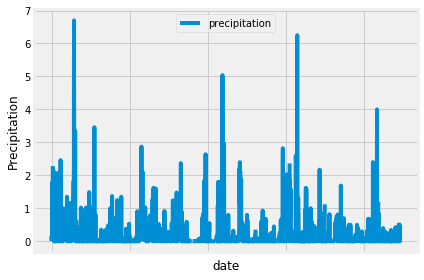

In [92]:
# Perform a query to retrieve the data and precipitation scores
prcp_data= session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df= pd.DataFrame(prcp_data, columns=["date","precipitation"])
prcp_df.set_index("date").head()


# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot("date", "precipitation")
plt.ylabel("Precipitation")
plt.legend(loc= "upper center")
plt.tight_layout()


In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [95]:
# Design a query to show how many stations are available in this dataset?
stations= session.query(Measurement.station).\
        group_by(Measurement.station).count()
print(stations)

9


In [116]:
# What are the most active stations? (i.e. what stations have the most rows)?
busy_stations= session.query(Measurement.station, func.count(Measurement.tobs)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc())
busiest_station= busy_stations.first()
print(f"Busiest station = Station {busiest_station[0]} with {busiest_station[1]} observations")

# List the stations and the counts in descending order.
print("Stations in descending order:")
for station in busy_stations:
    print(f"Station: {station[0]} with {station[1]} observations")


Busiest station = Station USC00519281 with 2772 observations
Stations in descending order:
Station: USC00519281 with 2772 observations
Station: USC00519397 with 2724 observations
Station: USC00513117 with 2709 observations
Station: USC00519523 with 2669 observations
Station: USC00516128 with 2612 observations
Station: USC00514830 with 2202 observations
Station: USC00511918 with 1979 observations
Station: USC00517948 with 1372 observations
Station: USC00518838 with 511 observations


In [132]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temps= session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == busiest_station[0]).all()
print(f"For busy station {busiest_station[0]}, min temp: {temps[0][0]}, max temp: {temps[0][1]}, avg temp: {temps[0][2]}")


For busy station USC00519281, min temp: 54.0, max temp: 85.0, avg temp: 71.66378066378067


In [154]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
lastyear_tobs= session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == busiest_station[0]).\
    order_by(Measurement.date).all()

#create dataframe
lastyear_tobs_df= pd.DataFrame(lastyear_tobs)
lastyear_tobs_df.head()

,date,station,tobs
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


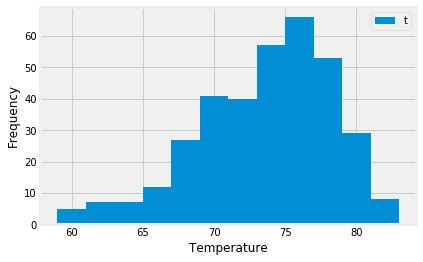

In [158]:
#create histogram
plt.hist(lastyear_tobs_df["tobs"], bins=12)
plt.legend("tobs", loc= "upper right")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.show()

In [165]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [166]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps= calc_temps("2017-08-11", "2017-08-20")
print(temps)

[(70.0, 78.34146341463415, 85.0)]


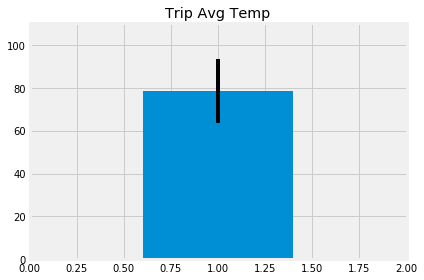

In [183]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin= temps[0][0]
avg_temps= temps[0][1]
tmax= temps[0][2]
peak= tmax - tmin

plt.bar(1, avg_temp)
plt.title("Trip Avg Temp")
plt.xlim(0,2)
plt.ylim(0,110)
plt.errorbar(1,avg_temps, yerr= peak, color= "black")
plt.tight_layout()
plt.show()


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
